In [1]:
import os
import time

import h5py
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as disp

from dataproc.dataproc import get_worm_data_files, explore_worm_files

In [2]:
# Get one example file set.

data_path = "./data_01/data"

main_file, feature_file, containing_dir_name = next(get_worm_data_files(data_path))

## Preprocessing of coordinates

###  View skeleton

In [3]:
# Notation: dc --> dorsal_contours
# Notation: vc --> ventral_contours
# Notation: sk --> skeletons
# Notation: skid --> skeleton_id

def retrieve_coordinates(f):
    dc = f["coordinates"]["dorsal_contours"]
    vc = f["coordinates"]["ventral_contours"]
    sk = f["coordinates"]["skeletons"]
    return dc, vc, sk

def retrive_skeleton_ids(f):
    skid = f["features_timeseries"]["skeleton_id"]
    return skid

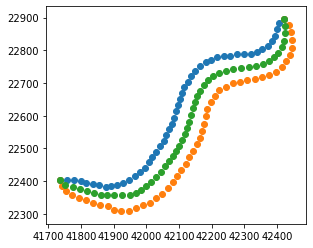

skid: 


In [4]:
# View some skeleton frames.

def view_coord_frames(dc, vc, sk, skid, from_=0, to=None, print_raw=False):
    
    if to is None:
        to = skid.shape[0]
    
    for t in range(from_, to):

        x_dc = dc[t, :, 0]
        y_dc = dc[t, :, 1]
        plt.scatter(x_dc, y_dc)

        x_vc = vc[t, :, 0]
        y_vc = vc[t, :, 1]
        plt.scatter(x_vc, y_vc)
        
        x_sk = sk[t, :, 0]
        y_sk = sk[t, :, 1]
        plt.scatter(x_sk, y_sk)

        ax = plt.gca()
        ax.set_aspect("equal")
        
        disp.display(plt.gcf())
        
        time.sleep(0.1)
        
        assert skid.shape[0] == dc.shape[0]
        
        print("skid: ".format(skid[t]))
        if skid[t] == -1:
            print("MISSING SKELETON!")
        
        if print_raw:
            print("x_dc={}".format(x_dc))
            print("y_dc={}".format(y_dc))
            print("x_vc={}".format(x_vc))
            print("y_vc={}".format(y_vc))
            print("x_sk={}".format(x_sk))
            print("y_sk={}".format(y_sk))
            print("skid[t]={}".format(skid[t]))
        
        disp.clear_output(wait=True)
        plt.close()

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    skid = retrive_skeleton_ids(f)
    
    view_coord_frames(dc, vc, sk, skid, from_=200, to=220)
    

###  Normalise

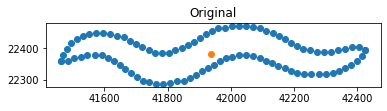

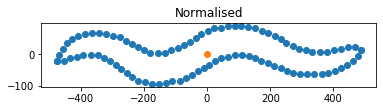

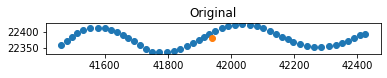

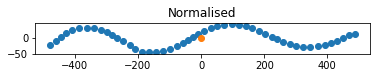

In [5]:
# Normalise (1) dorsal / ventral contours; (2) skeleton (center-line).

# NOTE: The contour is ordered in a continuous way (going [dc, vc]).
# Notation: com --> Centre of Mass

def normalise_dc_vc(dc, vc, limit=None):
    len_coords = dc.shape[1]
    num_frames = limit if ((limit is not None) and (dc.shape[0] > limit)) else dc.shape[0]
    
    frame_data = np.zeros((num_frames, len_coords * 2, 2))
    com = np.zeros((num_frames, 1, 2))
    
    for idx in range(num_frames):
        combined = np.stack((dc[idx, :, :], vc[idx, :, :]))
        frame_data[idx, :, :] = combined.reshape((-1, 2))
        com[idx, 0, :] = frame_data[idx, :, :].mean(axis=0)
    
    frame_data_norm = frame_data - com
    
    return frame_data, frame_data_norm, com

def normalise_sk(sk, limit=None):
    len_coords = sk.shape[1]
    num_frames = limit if ((limit is not None) and (sk.shape[0] > limit)) else sk.shape[0]
    
    frame_data = np.zeros((num_frames, len_coords, 2))
    com = np.zeros((num_frames, 1, 2))
    
    for idx in range(num_frames):
        frame_data[idx, :, :] = sk[idx, :, :].reshape((-1, 2))
        com[idx, 0, :] = frame_data[idx, :, :].mean(axis=0)
    
    frame_data_norm = frame_data - com
    
    return frame_data, frame_data_norm, com

def view_normalisation(frame_data, frame_data_norm, com, t=19):
    
    fig1 = plt.figure()
    plt.scatter(frame_data[t, :, 0], frame_data[t, :, 1])
    plt.scatter(com[t, 0, 0], com[t, 0, 1])
    plt.title("Original")
    ax = plt.gca()
    ax.set_aspect("equal")
    
    fig2 = plt.figure()
    plt.scatter(frame_data_norm[t, :, 0], frame_data_norm[t, :, 1])
    plt.scatter([0], [0])
    plt.title("Normalised")
    ax = plt.gca()
    ax.set_aspect("equal")

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    
    frame_data, frame_data_norm, com = normalise_dc_vc(dc, vc, limit=500)
    view_normalisation(frame_data, frame_data_norm, com, t=19)
    
    frame_data, frame_data_norm, com = normalise_sk(sk, limit=500)
    view_normalisation(frame_data, frame_data_norm, com, t=19)

### Missing frames

In [6]:
# Longest run detector helper.

arr = np.array([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

def longest_run(arr, value):
    max_run = 0
    bools = (arr == value).astype(int)
    if np.any(bools):
        bounded = np.hstack(([0], bools, [0]))
        diffs = np.diff(bounded)
        run_starts = np.where(diffs > 0)[0]
        run_ends = np.where(diffs < 0)[0]
        runs = run_ends - run_starts
        max_run = runs.max()
    return max_run

longest_run(arr, 1)

4

In [7]:
# Info on missing skeleton frames.

def missing_frames_info(missg, missing_indicator=-1):
    
    len_ = missg.shape[0]
    missing_count = (missg == missing_indicator).sum()
    missing_max_run = longest_run(missg, missing_indicator) 
    
    print("Missing skeletons: {}/{} ({:.3}%)".format(missing_count, len_, missing_count / len_ * 100))
    print("Longest run of missing skeletons: {}/{} ({:.3}%)".format(missing_max_run, len_, missing_max_run / len_ * 100))

with h5py.File(feature_file, "r") as f:
    
    skid = retrive_skeleton_ids(f)
    missing_frames_info(skid)

Missing skeletons: 471/26997 (1.74%)
Longest run of missing skeletons: 207/26997 (0.767%)


### Downsampling

In [8]:
# Experiment with downsampling, can be skipped.
SKIP_CELL = True
if not SKIP_CELL:

    KEEP_REPEATED = False

    mis = np.array([-1,-1, 2, 3, 4, 5, 6, 7, 8,-1,-1,-1,-1,13,14,15,16,17,-1,-1,-1,21,22,23,24,25,26,27,28,-1,30])

    period = 3
    missing_indicator = -1

    indices = np.array(range(len(mis)))
    # print("indices", indices)
    mod = np.remainder(indices, period)
    # print("mod", mod)
    take = (mod == 0).astype(int)
    print("take", take)

    mis_bool = (mis == missing_indicator).astype(int)
    print("mis_bool", mis_bool)

    mis_bool_inv = 1 - mis_bool
    print("mis_bool_inv", mis_bool_inv)

    comp = (mis_bool_inv & take).astype(int)
    print("comp", comp)
    comp_idx = np.where(comp)[0]
    print("* comp_idx", comp_idx)

    needs_filling = (mis_bool & take).astype(int)
    print("needs_filling", needs_filling)

    needs_filling_idx = np.where(needs_filling)[0]
    print("needs_filling_idx", needs_filling_idx)

    print("--------------------")
    bounded = np.hstack(([0], mis_bool, [0]))
    diffs = np.diff(bounded)
    run_starts = np.where(diffs[1:] > 0)[0]
    run_ends = np.where(diffs[:-1] < 0)[0]
    run_edges = np.sort(np.concatenate((run_starts, run_ends)))
    print("run_starts", run_starts)
    print("run_ends", run_ends)
    print("run_edges", run_edges)

    print("--------------------")
    fill = np.zeros((needs_filling_idx.shape[0])).astype(int)
    for enum_idx, idx in enumerate(needs_filling_idx):
        diff = np.absolute(run_edges - idx)
        diff_argmin = diff.argmin()
        print("diff", diff)
        print("diff_argmin", diff_argmin)
        use_idx = run_edges[diff_argmin]
        print("use_idx", use_idx)
        fill[enum_idx] = use_idx
    print("* fill", fill)

    final = np.sort(np.concatenate((comp_idx, fill)))
    print("** final", final)

    expected_count = take.sum()
    actual_count = final.shape[0]
    print("expected_count =", expected_count, "... actual_count =", actual_count)
    assert expected_count == actual_count

    print("--------------------")
    print("KEEP_REPEATED =", KEEP_REPEATED)
    if not KEEP_REPEATED:
        final = np.unique(final)
    print("** final", final)

In [9]:
# Downasampling as function.

def get_downsample_clean_frames(missg, period, keep_repeated=True, missing_indicator=1):
    """
    Return indices of frames after downsampling, up to length of `missg` (this is the total number of frames).
    
    Note:
        
        Will take frames every `period`-many frames, unless this falls on a missing frame (`missg == missing_indicator`) or on a region of such frames.
        In that case, the closest frame that is not missing will be taken.#
        
        In case N (more than one) consecutive `period`-many frames fall on a consecutive missing region, `keep_repeated` affects the output:
            * if `keep_repeated=True`, will return the same closest non-missing frame N times.
            * if `keep_repeated=False`, will return the same closest non-missing frame only once. 
    """

    indices = np.array(range(len(missg)))
    mod = np.remainder(indices, period)
    take = (mod == 0).astype(int)

    mis_bool = (missg == missing_indicator).astype(int)

    mis_bool_inv = 1 - mis_bool
    
    if mis_bool_inv.sum() == 0:
        raise ValueError("All values missing, cannot downsample.")

    comp = (mis_bool_inv & take).astype(int)
    comp_idx = np.where(comp)[0]

    needs_filling = (mis_bool & take).astype(int)

    needs_filling_idx = np.where(needs_filling)[0]

    bounded = np.hstack(([0], mis_bool, [0]))
    diffs = np.diff(bounded)
    run_starts = np.where(diffs[1:] > 0)[0]
    run_ends = np.where(diffs[:-1] < 0)[0]
    run_edges = np.sort(np.concatenate((run_starts, run_ends)))

    fill = np.zeros((needs_filling_idx.shape[0])).astype(int)
    for enum_idx, idx in enumerate(needs_filling_idx):
        diff = np.absolute(run_edges - idx)
        diff_argmin = diff.argmin()
        use_idx = run_edges[diff_argmin]
        fill[enum_idx] = use_idx

    final = np.sort(np.concatenate((comp_idx, fill)))

    expected_count = take.sum()
    actual_count = final.shape[0]
    assert expected_count == actual_count
    
    if not keep_repeated:
        final = np.unique(final)
    
    return final

# Test:
mis = np.array([-1,-1, 2, 3, 4, 5, 6, 7, 8,-1,-1,-1,-1,13,14,15,16,17,-1,-1,-1,21,22,23,24,25,26,27,28,-1,30])
result = get_downsample_clean_frames(mis, period=5, keep_repeated=True)
# Edge cases:
# result = get_downsample_clean_frames(mis, period=2, keep_repeated=True)
# result = get_downsample_clean_frames(mis, period=2, keep_repeated=False)
# result = get_downsample_clean_frames(mis, period=1, keep_repeated=True)
# result = get_downsample_clean_frames(mis, period=1, keep_repeated=False)
# result = get_downsample_clean_frames(np.array((-1, -1, -1)), period=1, keep_repeated=False)  # Exception
print(result)

[ 0  5 10 15 20 25 30]


In [10]:
# Additional (nan-based, manual) check for missing coordinates.
def missing_check_coordinates(tuple_of_arrays):
    list_result = []
    for arr in tuple_of_arrays:
        dim0_shape = arr.shape[0]
        result = np.zeros((dim0_shape,)).astype(int)
        for idx in range(dim0_shape):
            frame = arr[idx, :]
            missing = np.any(np.isnan(frame))
            if missing:
                result[idx] = 1
        list_result.append(result)
    return tuple(list_result)

def missing_check_coordinates_pll(tuple_of_arrays):
    list_result = []
    for arr in tuple_of_arrays:
        result = np.any(np.isnan(arr), axis=(1, 2)).astype(int)
        list_result.append(result)
    return tuple(list_result)

In [11]:
%%time
# Test downasampling function on actual data: **prepare**.

def generate_missing(dc, vc, sk, skid):
    missing_based_on_skid_alone = (skid == -1).astype(int)
    
    # Old: manual_missing = missing_check_coordinates((dc, vc, sk))
    manual_missing = missing_check_coordinates_pll((dc, vc, sk))
    
    dc_m, vc_m, sk_m = manual_missing
    
    # Old vs new check:
    # print(np.all(dc_m == dc_m2))
    # print(np.all(vc_m == vc_m2))
    # print(np.all(sk_m == sk_m2))
    
    missing_for_any_reason = (dc_m | vc_m | sk_m | missing_based_on_skid_alone)
    
    return missing_based_on_skid_alone, missing_for_any_reason

def downsample_clean(tuple_of_arrays, downsample_idx):
    list_result = []
    for arr in tuple_of_arrays:
        list_result.append(np.take(arr, downsample_idx, axis=0))
    return tuple(list_result)

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    skid = retrive_skeleton_ids(f)
    
    skid_m, missing_for_any_reason = generate_missing(dc, vc, sk, skid)
    
    print("Using skeleton_ids only:")
    missing_frames_info(skid_m, missing_indicator=1)
    print("\nUsing missing_for_any_reason:")
    missing_frames_info(missing_for_any_reason, missing_indicator=1)
    
    downsample_idx = get_downsample_clean_frames(missing_for_any_reason, period=20, keep_repeated=True, missing_indicator=1)
    print("\nDownsampled frames (shape: {}):\n{}\n".format(downsample_idx.shape, downsample_idx))
    
    to_downsample = (dc, vc, sk, skid)
    downsampled = downsample_clean(to_downsample, downsample_idx)
    for idx, d in enumerate(downsampled):
        print("Before shape: {}".format(to_downsample[idx].shape))
        print("After shape: {}".format(d.shape))

Using skeleton_ids only:
Missing skeletons: 471/26997 (1.74%)
Longest run of missing skeletons: 207/26997 (0.767%)

Using missing_for_any_reason:
Missing skeletons: 636/26997 (2.36%)
Longest run of missing skeletons: 272/26997 (1.01%)

Downsampled frames (shape: (1350,)):
[    0    20    40 ... 26940 26960 26980]

Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997, 49, 2)
After shape: (1350, 49, 2)
Before shape: (26997,)
After shape: (1350,)
CPU times: user 316 ms, sys: 12 ms, total: 328 ms
Wall time: 327 ms


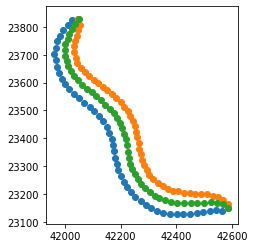

skid: 


In [12]:
# Test downasampling function on actual data: **visualise**.

with h5py.File(feature_file, "r") as f:
    dc_, vc_, sk_, skid_ = downsampled
    view_coord_frames(dc_, vc_, sk_, skid_, from_=0, to=40, print_raw=False)

## Invariant representation

In [13]:
# Investigate a way to calculate the angles.

def unit_vector(vector):
    if np.array_equal(vector, np.zeros((2))):
        raise ValueError("`angle_between` doens't allow [0., 0.] point.")
    else:
        return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    
    sign = int((v2_u - v1_u)[1] >= 0) - int((v2_u - v1_u)[1] < 0)
    
    # print("---")
    
    # print("v1_u", v1_u)
    # print("v2_u", v2_u)
    
    # print("sign", sign)
    
    dot = np.dot(v1_u, v2_u)
    # print("dot", dot)

    if np.array_equal(v1_u, v2_u):
        # print("0!")
        result = 0.
    elif np.array_equal(v1_u, -1. * v2_u):
        # print("::: ", (v2_u - v1_u)[1])
        # print("::: pi!")
        result = np.pi
    else:
        # print("::: ", (v2_u - v1_u)[1])
        result = np.arccos(np.clip(np.dot(v1_u, v2_u), -1., 1.))
        if np.isnan(result):
            print(v1, v2)
            print(v1_u, v2_u)
            raise RuntimeError("`angle_between` result got `nan`.")
            
    # print("acos", result)
    
    return result, sign

def angle_between_pll(v1, v2):
    """
    Calculate angle between [v1] and [v2 0th axis elements].
    Sign values give the direction of the rotation for this angles.
    """
    v1_u = v1 / np.linalg.norm(v1)
    
    #print("v1", v1)
    #print("v2", v2)
    
    norm = np.tile(np.linalg.norm(v2, axis=1), (2, 1)).T
    # print("norm", norm)
    v2_u = v2 / norm
    
    # print("v1_u", v1_u)
    # print("v2_u", v2_u[:2, :])
    
    sign = ((v2_u - v1_u)[:, 1] >= 0).astype(int) - ((v2_u - v1_u)[:, 1] < 0).astype(int)
    # print(sign.shape)
    # print("sign", sign[:2])
    
    dot = np.dot(v1_u, v2_u.T).T
    # print(dot.shape)
    # print("dot", dot[:2])
    
    clip = np.clip(dot, -1., 1.)
    # print(clip.shape)
    # print("clip", clip[:2])
    
    acos = np.arccos(clip)
    # print(acos.shape)
    # print("acos", acos[:2])
    
    if np.isnan(acos).sum() > 0 or np.isnan(sign).sum() > 0:
        raise ValueError("NaN found in `acos` or `sign`.")
    
    return acos, sign

# Test:
for l in (
    [[1., 0.], [0., 3.]], 
    [[1., 0.], [2., 2.]], 
    [[1., 1.], [8., 8.]], 
    [[0., 100.000001], [0., 1.]],
    [[1., 1.], [-2., -2.]]):
    
    pts = np.array(l)
    print("pts: \n", pts)
    
    pt1 = pts[0, :]
    pt2 = pts[1, :]
    pt2_unsqueezed = np.array([pt2])
    # old: angle, _ = angle_between(pt1, pt2)
    angle, _ = angle_between_pll(pt1, pt2_unsqueezed)
    print("angle: ", angle)
    print("i.e. pi *", angle / np.pi)
    print()

pts: 
 [[1. 0.]
 [0. 3.]]
angle:  [1.57079633]
i.e. pi * [0.5]

pts: 
 [[1. 0.]
 [2. 2.]]
angle:  [0.78539816]
i.e. pi * [0.25]

pts: 
 [[1. 1.]
 [8. 8.]]
angle:  [2.10734243e-08]
i.e. pi * [6.70787928e-09]

pts: 
 [[  0.       100.000001]
 [  0.         1.      ]]
angle:  [0.]
i.e. pi * [0.]

pts: 
 [[ 1.  1.]
 [-2. -2.]]
angle:  [3.14159263]
i.e. pi * [0.99999999]



In [14]:
# Extract a frame for testing.

with h5py.File(feature_file, "r") as f:
    
    dc, vc, sk = retrieve_coordinates(f)
    t = 400
    
    frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc = normalise_dc_vc(dc, vc, limit=500)   
    frame_data_sk, frame_data_norm_sk, com_sk = normalise_sk(sk, limit=500)
    
    cont, dc_vc_norm, dc_vc_com = frame_data_dc_vc[t, :], frame_data_norm_dc_vc[t, :], com_dc_vc[t, :]
    sk, sk_norm, sk_com = frame_data_sk[t, :], frame_data_norm_sk[t, :], com_sk[t, :]

[CONTOURS] CLOSE ENOUGH:  True
[SKELETON] CLOSE ENOUGH:  True


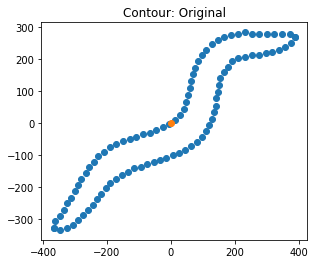

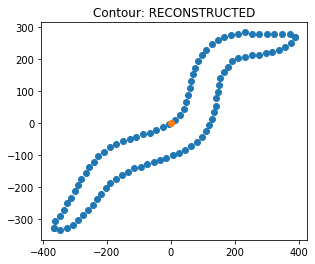

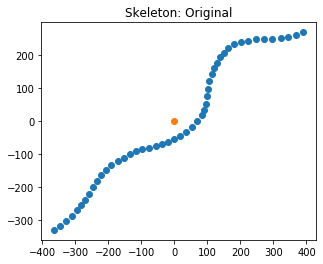

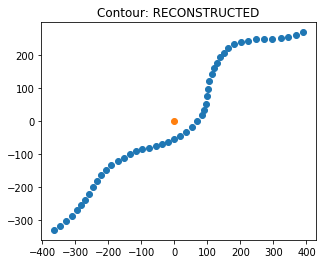

In [15]:
# %%timeit -n 10 -r 10

# Test on a frame.

def view_angle_length(frame_data_norm, title):
    
    fig2 = plt.figure()
    plt.scatter(frame_data_norm[:, 0], frame_data_norm[:, 1])
    plt.scatter([0], [0])
    plt.title(title)
    ax = plt.gca()
    ax.set_aspect("equal")

def get_angle_length_repr(coords):
    # print(coords.shape)
    first_coord = coords[0, :]
    
    diff_vecs = np.diff(coords, axis=0)
    
    hor_vec = np.array([1., 0.])
    angles = np.zeros(coords.shape[0] - 1)
    signs = np.zeros(coords.shape[0] - 1)
    for idx, dv in enumerate(diff_vecs):
        angles[idx], signs[idx] = angle_between(hor_vec, dv)
        # print(angles[idx])
    
    # print(diff_vecs.shape)
    # print("signs", signs)
    
    lens = np.linalg.norm(diff_vecs, axis=1)
    
    # print(diff_vecs[:10, :])
    # print(angles[:10])
    
    # print(lens)
    
    return angles, signs, lens, first_coord
    
def get_angle_length_repr_pll(coords):
    # print(coords.shape)
    first_coord = coords[0, :]
    
    diff_vecs = np.diff(coords, axis=0)
    
    hor_vec = np.array([1., 0.])
    angles = np.zeros(coords.shape[0] - 1)
    signs = np.zeros(coords.shape[0] - 1)
    
    # print(diff_vecs.shape)
    
    angles, signs = angle_between_pll(hor_vec, diff_vecs)
    
    lens = np.linalg.norm(diff_vecs, axis=1)
    
    return angles, signs, lens, first_coord

def reverse_angle_length_repr(angles, signs, lens, first_coord):
    coss = np.cos(angles)
    sins = np.sin(angles)
    # print("---")
    # print(coss[:9])
    # print(sins[:9])
    result = np.zeros((1 + angles.shape[0], 2))
    result[0, :] = first_coord
    # print(result[:9])
    for idx, val in enumerate(lens):
        result[idx + 1, 0] = result[idx, 0] + lens[idx] * coss[idx]
        result[idx + 1, 1] = result[idx, 1] + lens[idx] * sins[idx] * signs[idx]
    # print(result[:9])
    return result

def reverse_angle_length_repr_pll(angles, signs, lens, first_coord=None):
        
    if first_coord is None:
        first_coord = np.array([0., 0.])
        
    _angles = np.pad(angles, (1,0), 'constant', constant_values=(0,))
    _signs = np.pad(signs, (1,0), 'constant', constant_values=(0,))
    _lens = np.pad(lens, (1,0), 'constant', constant_values=(0,))
    
    _coss = np.cos(_angles)
    _sins = np.sin(_angles)
    
    result = np.zeros((1 + angles.shape[0], 2))
    result[0, :] = first_coord
    
    # print("angles.shape", _angles.shape)
    # print("_coss.shape", _coss.shape)
    # print("_lens.shape", _lens.shape)
    # print("result.shape", result.shape)
    
    x_add = result[:, 0] + _lens * _coss
    y_add = result[:, 1] + _lens * _sins * _signs
    
    result[:, 0] = np.add.accumulate(x_add)
    result[:, 1] = np.add.accumulate(y_add)
    
    if np.isnan(result).sum() > 0:
        raise ValueError("NaN found in `result`.")
    
    return result



# CONTOURS:

# print("dc_vc_norm \n", dc_vc_norm[:15, :])

# Old: angles, signs, lens, first_coord = get_angle_length_repr(dc_vc_norm)
angles, signs, lens, first_coord = get_angle_length_repr_pll(dc_vc_norm)  # Much faster
# Old vs new check:
# print(np.all(angles1 == angles2))
# print(np.all(signs1 == signs2))
# print(np.all(lens1 == lens2))
# print(np.all(first_coord1 == first_coord2))

# print("angles \n", angles[:14])
# print("signs \n", signs[:14])
# print("lens \n", lens[:14])

# Old: dc_vc_norm_r = reverse_angle_length_repr(angles, signs, lens, first_coord)  # Notation: _r --> _reconstructed.
dc_vc_norm_r = reverse_angle_length_repr_pll(angles, signs, lens, first_coord)  # Notation: _r --> _reconstructed.
# Old vs new check:
# print(np.all(dc_vc_norm_r == dc_vc_norm_r2))

# print("dc_vc_norm_r", dc_vc_norm_r[:5,:])
# print("dc_vc_norm_r2", dc_vc_norm_r2[:5,:])

# print("dc_vc_norm_r \n", dc_vc_norm_r[:, :])

# print(dc_vc_norm_r.shape)
# print(dc_vc_norm.shape)

close_enough = np.all(np.isclose(dc_vc_norm_r, dc_vc_norm))
print("[CONTOURS] CLOSE ENOUGH: ", close_enough)

view_angle_length(dc_vc_norm, title="Contour: Original")
view_angle_length(dc_vc_norm_r, title="Contour: RECONSTRUCTED")



# SKELETON:

# print(dc_vc_norm.shape)
# print(angles.shape, signs.shape, lens.shape, first_coord.shape)

angles, signs, lens, first_coord = get_angle_length_repr_pll(sk_norm)
sk_norm_r = reverse_angle_length_repr_pll(angles, signs, lens, first_coord)
close_enough = np.all(np.isclose(sk_norm_r, sk_norm))
print("[SKELETON] CLOSE ENOUGH: ", close_enough)

view_angle_length(sk_norm, title="Skeleton: Original")
view_angle_length(sk_norm_r, title="Contour: RECONSTRUCTED")

[Contours]
lens_norm.sum() = 0.9999999999999998
signed_angles_norm.mean() = 1.0072126408970492e-16
[Skeleton]
lens_norm.sum() = 1.0000000000000002
signed_angles_norm.mean() = 2.0354088784794536e-16


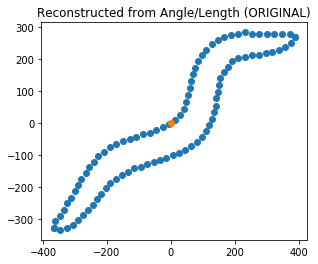

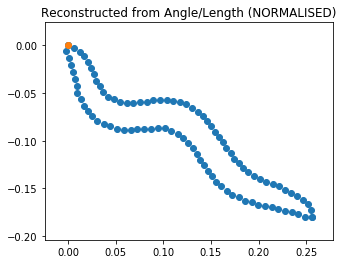

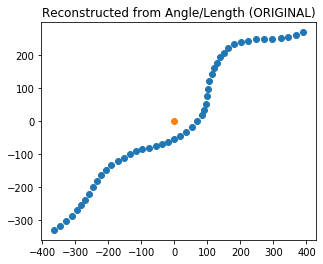

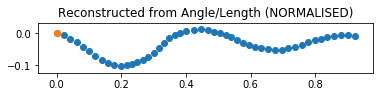

In [16]:
# Investigate normalising the angle/length representation.

def normalise_angle_sign_repr_frame(angles, signs, lens, first_coord):
    """
    NOTE: BE CAREFUL WITH THIS - ONLY `angles_norm * signs_norm` IS NORMALISED (NOT `angles_norm`).
    """
    
    # Angles and signs.
    signed_angles = angles * signs
    angles_norm = signed_angles - signed_angles.mean()
    signs_norm = (angles_norm >= 0).astype(int) - (angles_norm < 0).astype(int)
    angles_norm = np.absolute(angles_norm)
    
    # Lengths.
    lens_norm = lens / lens.sum()
    
    return angles_norm, signs_norm, lens_norm

def normalise_angle_sign_repr(angles, signs, lens, first_coord):
    """
    NOTE: BE CAREFUL WITH THIS - ONLY `angles_norm * signs_norm` IS NORMALISED (NOT `angles_norm`).
    """
    
    angles_norm_ARR = np.zeros_like(angles)
    signs_norm_ARR = np.zeros_like(signs)
    lens_norm_ARR = np.zeros_like(lens)
    
    for idx in range(angles.shape[0]):
        
        angles_, signs_, lens_ = angles[idx, :], signs[idx, :], lens[idx, :]
        
        # Angles and signs.
        signed_angles = angles_ * signs_
        angles_norm = signed_angles - signed_angles.mean()
        signs_norm = (angles_norm >= 0).astype(int) - (angles_norm < 0).astype(int)
        angles_norm = np.absolute(angles_norm)

        # Lengths.
        lens_norm = lens_ / lens_.sum()
        
        angles_norm_ARR[idx], signs_norm_ARR[idx], lens_norm_ARR[idx] = angles_norm, signs_norm, lens_norm

    return angles_norm_ARR, signs_norm_ARR, lens_norm_ARR
    

## DC_VC
print("[Contours]")
    
# Before normalisation.
angles, signs, lens, first_coord = get_angle_length_repr_pll(dc_vc_norm)
dc_vc_norm_r = reverse_angle_length_repr_pll(angles, signs, lens, first_coord)

view_angle_length(dc_vc_norm_r, title="Reconstructed from Angle/Length (ORIGINAL)")

# Normalisation.
angles_norm, signs_norm, lens_norm = normalise_angle_sign_repr_frame(angles, signs, lens, first_coord)

print("lens_norm.sum() =", lens_norm.sum())
signed_angles_norm = angles_norm * signs_norm
print("signed_angles_norm.mean() =", signed_angles_norm.mean())

# Reconstruct and view.
dc_vc_norm_r_norm = reverse_angle_length_repr_pll(angles_norm, signs_norm, lens_norm, None)
view_angle_length(dc_vc_norm_r_norm, title="Reconstructed from Angle/Length (NORMALISED)")


## SK
print("[Skeleton]")

angles, signs, lens, first_coord = get_angle_length_repr_pll(sk_norm)
sk_norm_r = reverse_angle_length_repr_pll(angles, signs, lens, first_coord)

view_angle_length(sk_norm_r, title="Reconstructed from Angle/Length (ORIGINAL)")

# Normalisation.
angles_norm, signs_norm, lens_norm = normalise_angle_sign_repr_frame(angles, signs, lens, first_coord)

print("lens_norm.sum() =", lens_norm.sum())
signed_angles_norm = angles_norm * signs_norm
print("signed_angles_norm.mean() =", signed_angles_norm.mean())

# Reconstruct and view.
sk_norm_r_norm = reverse_angle_length_repr_pll(angles_norm, signs_norm, lens_norm, None)
view_angle_length(sk_norm_r_norm, title="Reconstructed from Angle/Length (NORMALISED)")

In [17]:
# Prepare all frames.
with h5py.File(feature_file, "r") as f:

    # Prep data.
    dc, vc, sk = retrieve_coordinates(f)
    skid = retrive_skeleton_ids(f)

    skid_m, missing_for_any_reason = generate_missing(dc, vc, sk, skid)
    missing_frames_info(missing_for_any_reason, missing_indicator=1)

    
    
    # Clean (want to avoid any frames with missing skeletons / contours).
    period_clean = 1
    clean_idx = get_downsample_clean_frames(missing_for_any_reason, period=1, keep_repeated=True, missing_indicator=1)
    to_clean = (dc, vc, sk, skid)
    dc_c, vc_c, sk_c, skid_c = downsample_clean(to_clean, clean_idx)  # Notation: _c --> _cleaned.
    # Check:
    assert dc_c.shape[0] == dc.shape[0]  # Total of frames.
    
    

    # Normalise:
    frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc = normalise_dc_vc(dc_c, vc_c, limit=None)
    frame_data_sk, frame_data_norm_sk, com_sk = normalise_sk(sk_c, limit=None)

Missing skeletons: 636/26997 (2.36%)
Longest run of missing skeletons: 272/26997 (1.01%)


In [18]:
%%time
# Test on all frames.

def get_angle_length_repr(
    frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc, 
    frame_data_sk, frame_data_norm_sk, com_sk, 
    ckeck=True, limit=None, log=True):

    frames_count = frame_data_sk.shape[0]
    limit_ = frames_count if limit is None else limit
    
    new_array_dim1 = frame_data_norm_dc_vc.shape[1] - 1
    angles_dc_vc_ARR = np.zeros((limit_, new_array_dim1))
    signs_dc_vc_ARR = np.zeros((limit_, new_array_dim1))
    lens_dc_vc_ARR = np.zeros((limit_, new_array_dim1))
    first_coord_dc_vc_ARR = np.zeros((limit_, 2))
    
    new_array_dim1 = frame_data_norm_sk.shape[1] - 1
    angles_sk_ARR = np.zeros((limit_, new_array_dim1))
    signs_sk_ARR = np.zeros((limit_, new_array_dim1))
    lens_sk_ARR = np.zeros((limit_, new_array_dim1))
    first_coord_sk_ARR = np.zeros((limit_, 2))
    
    if ckeck:
        close_enoughs_dc_vc = np.zeros((limit_,)).astype(bool)
        close_enoughs_sk = np.zeros((limit_,)).astype(bool)

    for t in range(limit_):

        cont, dc_vc_norm, dc_vc_com = frame_data_dc_vc[t, :], frame_data_norm_dc_vc[t, :], com_dc_vc[t, :]
        sk, sk_norm, sk_com = frame_data_sk[t, :], frame_data_norm_sk[t, :], com_sk[t, :]

        # CONTOURS:
        angles_dc_vc, signs_dc_vc, lens_dc_vc, first_coord_dc_vc = get_angle_length_repr_pll(dc_vc_norm)
        # Check:
        if ckeck:
            dc_vc_norm_r = reverse_angle_length_repr_pll(angles_dc_vc, signs_dc_vc, lens_dc_vc, first_coord_dc_vc)
            close_enoughs_dc_vc[t] = np.all(np.isclose(dc_vc_norm_r, dc_vc_norm))
        # Save:
        angles_dc_vc_ARR[t] = angles_dc_vc
        signs_dc_vc_ARR[t] = signs_dc_vc
        lens_dc_vc_ARR[t] = lens_dc_vc
        first_coord_dc_vc_ARR[t] = first_coord_dc_vc

        # SKELETON:
        angles_sk, signs_sk, lens_sk, first_coord_sk = get_angle_length_repr_pll(sk_norm)
        # Check:
        if ckeck:
            sk_norm_r = reverse_angle_length_repr_pll(angles_sk, signs_sk, lens_sk, first_coord_sk)
            close_enoughs_sk[t] = np.all(np.isclose(sk_norm_r, sk_norm))
        # Save:
        angles_sk_ARR[t] = angles_sk
        signs_sk_ARR[t] = signs_sk
        lens_sk_ARR[t] = lens_sk
        first_coord_sk_ARR[t] = first_coord_sk
        
    # Final ckeck:
    if ckeck:
        
        if log:
            print("[CONTOURS] Success rate: {}/{} ({}%)".format(int(close_enoughs_dc_vc.sum()), close_enoughs_dc_vc.shape[0], close_enoughs_dc_vc.sum() / close_enoughs_dc_vc.shape[0]))
            print("[SKELETONS] Success rate: {}/{} ({}%)".format(int(close_enoughs_sk.sum()), close_enoughs_sk.shape[0], close_enoughs_sk.sum() / close_enoughs_sk.shape[0]))
        
        if not (np.all(close_enoughs_dc_vc) and np.all(close_enoughs_sk)):
            raise RuntimeError("Failed `get_angle_length_repr` consistency check.")
    
    return (angles_dc_vc_ARR, signs_dc_vc_ARR, lens_dc_vc_ARR, first_coord_dc_vc_ARR), (angles_sk_ARR, signs_sk_ARR, lens_sk_ARR, first_coord_sk_ARR)

_ = get_angle_length_repr(
    frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc, 
    frame_data_sk, frame_data_norm_sk, com_sk, 
    ckeck=True, limit=1000)

[CONTOURS] Success rate: 1000/1000 (1.0%)
[SKELETONS] Success rate: 1000/1000 (1.0%)
CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 795 ms


## Full run 

In [19]:
%%time



def preprocess_feature_file(feature_file, downsample_period=5, log=True):
    
    cleaned_key = "cleaned"
    downsampled_key = "downsampled"
    
    output = {cleaned_key: dict(), downsampled_key: dict(), "downsample_period": downsample_period}
    
    
    
    with h5py.File(feature_file, "r") as f:
        
        # Prep data.
        dc, vc, sk = retrieve_coordinates(f)
        skid = retrive_skeleton_ids(f)
        if log:
            print("\nShapes of dc, vc, sk, skid [original]:")
            print(dc.shape, vc.shape, sk.shape, skid.shape)

        skid_m, missing_for_any_reason = generate_missing(dc, vc, sk, skid)
        missing_frames_info(missing_for_any_reason, missing_indicator=1)



        # Clean.
        period_clean = 1
        clean_idx = get_downsample_clean_frames(missing_for_any_reason, period=1, keep_repeated=True, missing_indicator=1)
        to_clean = (dc, vc, sk, skid)
        dc_c, vc_c, sk_c, skid_c = downsample_clean(to_clean, clean_idx)  # Notation: _c --> _cleaned.
        # Check:
        assert dc_c.shape[0] == dc.shape[0]  # Total of frames.
        # Print:
        if log:
            print("\nShapes of dc_c, vc_c, sk_c, skid_c [cleaned]:")
            print(dc_c.shape, vc_c.shape, sk_c.shape, skid_c.shape)
        # Output:
        output[cleaned_key]["coords"] = {"dc": dc_c, "vc": vc_c, "sk": sk_c, "skid": skid_c}

        # Downsample.
        downsample_idx = get_downsample_clean_frames(missing_for_any_reason, period=downsample_period, keep_repeated=True, missing_indicator=1)
        to_downsample = (dc, vc, sk, skid)
        dc_d, vc_d, sk_d, skid_d = downsample_clean(to_downsample, downsample_idx)  # Notation: _c --> _downsampled.
        # Print:
        if log:
            print("\nShapes of dc_d, vc_d, sk_d, skid_d [downsampled (and cleaned)]:")
            print(dc_d.shape, vc_d.shape, sk_d.shape, skid_d.shape)
            print()
        # Output:
        output[downsampled_key]["coords"] = {"dc": dc_d, "vc": vc_d, "sk": sk_d, "skid": skid_d}



        # Normalise cleaned data.
        for key, (dc_, vc_, sk_) in { cleaned_key: (dc_c, vc_c, sk_c), downsampled_key: (dc_d, vc_d, sk_d) }.items():
            frame_data_dc_vc, frame_data_norm_dc_vc, com_dc_vc = normalise_dc_vc(dc_, vc_, limit=None)
            frame_data_sk, frame_data_norm_sk, com_sk = normalise_sk(sk_, limit=None)
            output[key]["coords_normalised"] = {
                "dc_vc": {"data": frame_data_dc_vc, "data_norm": frame_data_norm_dc_vc, "com": com_dc_vc}, 
                "sk": {"data": frame_data_sk, "data_norm": frame_data_norm_sk, "com": com_sk} }
        
        
        
        # Get Angle/Length representation & normalise:
        for key in (cleaned_key, downsampled_key):
            dc_vc_normalised = output[key]["coords_normalised"]["dc_vc"]
            sk_normalised = output[key]["coords_normalised"]["sk"]
            (angles_dc_vc, signs_dc_vc, lens_dc_vc, first_coord_dc_vc), (angles_sk, signs_sk, lens_sk, first_coord_sk) = \
                get_angle_length_repr(
                    dc_vc_normalised["data"], dc_vc_normalised["data_norm"], dc_vc_normalised["com"], 
                    sk_normalised["data"], sk_normalised["data_norm"], sk_normalised["com"], 
                    ckeck=True, limit=None, log=False)
            output[key]["angle_repr"] = {
                "dc_vc": {"angle": angles_dc_vc, "sign": signs_dc_vc, "len": lens_dc_vc, "first_coord": first_coord_dc_vc}, 
                "sk": {"angle": angles_sk, "sign": signs_sk, "len": lens_sk, "first_coord": first_coord_sk} }
            
            # Get normalised Angle/Length representation - "Invariant representation".
            angles_norm_dc_vc, signs_norm_dc_vc, lens_norm_dc_vc = normalise_angle_sign_repr(angles_dc_vc, signs_dc_vc, lens_dc_vc, first_coord_dc_vc)
            angles_norm_sk, signs_norm_sk, lens_norm_sk = normalise_angle_sign_repr(angles_sk, signs_sk, lens_sk, first_coord_sk)
            output[key]["angle_repr_normalised"] = {
                "dc_vc": {"angle": angles_norm_dc_vc, "sign": signs_norm_dc_vc, "len": lens_norm_dc_vc}, 
                "sk": {"angle": angles_norm_sk, "sign": signs_norm_sk, "len": lens_norm_sk} }
    
    
    
    return output



output = preprocess_feature_file(feature_file, downsample_period=5, log=True)


Shapes of dc, vc, sk, skid [original]:
(26997, 49, 2) (26997, 49, 2) (26997, 49, 2) (26997,)
Missing skeletons: 636/26997 (2.36%)
Longest run of missing skeletons: 272/26997 (1.01%)

Shapes of dc_c, vc_c, sk_c, skid_c [cleaned]:
(26997, 49, 2) (26997, 49, 2) (26997, 49, 2) (26997,)

Shapes of dc_d, vc_d, sk_d, skid_d [downsampled (and cleaned)]:
(5400, 49, 2) (5400, 49, 2) (5400, 49, 2) (5400,)

CPU times: user 28.7 s, sys: 151 ms, total: 28.8 s
Wall time: 28.8 s


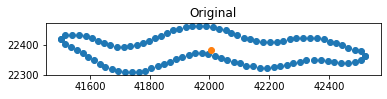

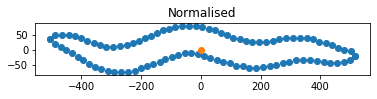

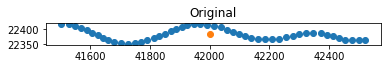

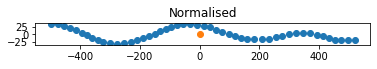

In [20]:
# Show some normalised data (from "cleaned").

t = 3  # Frame number.

frame_data, frame_data_norm, com = tuple(output["cleaned"]["coords_normalised"]["dc_vc"].values())  # Note: dict key order is preserved by default from Python 3.7.
view_normalisation(frame_data, frame_data_norm, com, t=t)

frame_data, frame_data_norm, com = tuple(output["cleaned"]["coords_normalised"]["sk"].values())
view_normalisation(frame_data, frame_data_norm, com, t=t)

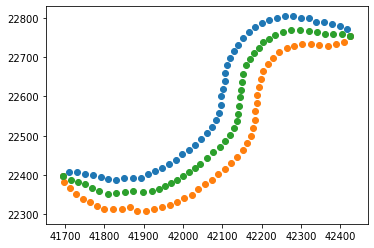

skid: 


In [21]:
# Show some frames.
dc_d, vc_d, sk_d, skid_d = tuple(list(output["downsampled"]["coords"].values())[:4])
view_coord_frames(dc_d, vc_d, sk_d, skid_d, from_=0, to=40, print_raw=False)

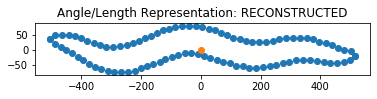

In [22]:
# Show some data from angle_length representation.

t = 3

angles_dc_vc, signs_dc_vc, lens_dc_vc, first_coord_dc_vc = tuple(output["cleaned"]["angle_repr"]["dc_vc"].values())
# angles_sk, signs_sk, lens_sk, first_coord_sk = tuple(output["cleaned"]["angle_repr"]["sk"].values())

dc_vc_norm_r = reverse_angle_length_repr_pll(angles_dc_vc[t, :], signs_dc_vc[t, :], lens_dc_vc[t, :], first_coord_dc_vc[t, :])
view_angle_length(dc_vc_norm_r, title="Angle/Length Representation: RECONSTRUCTED")

DC_VC:
lens sum:  1.0000000000000002
signed angles mean:  -1.3734717830414308e-16


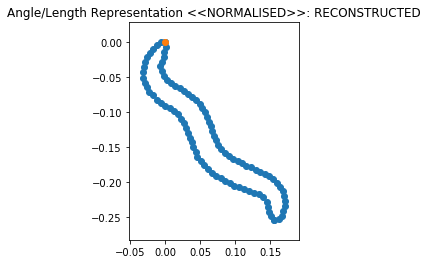

In [31]:
# Show some data from NORMALISED angle_length representation.


angles_norm_dc_vc, signs_norm_dc_vc, lens_norm_dc_vc = tuple(output["downsampled"]["angle_repr_normalised"]["dc_vc"].values())
# angles_sk, signs_sk, lens_sk = tuple(output["cleaned"]["angle_repr"]["sk"].values())

from_ = 40
to_ = 60
for t in range(from_, to_):
    
    if t == to_-1:
        # Print info.
        print("DC_VC:")
        print("lens sum: ", lens_norm_dc_vc[t, :].sum())
        print("signed angles mean: ", (signs_norm_dc_vc[t, :]*angles_norm_dc_vc[t, :]).mean())

    dc_vc_norm_r_norm = reverse_angle_length_repr_pll(angles_norm_dc_vc[t, :], signs_norm_dc_vc[t, :], lens_norm_dc_vc[t, :], None)
    
    view_angle_length(dc_vc_norm_r_norm, title="Angle/Length Representation <<NORMALISED>>: RECONSTRUCTED")
    
    disp.display(plt.gcf())
    
    time.sleep(0.1)
    
    disp.clear_output(wait=True)
    plt.close()